# XGB classfier

In [3]:
# modules and libraries
import time
import os
import glob
import datetime
import time as tiempos
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import ifft
from scipy.fftpack import fft
import scipy
import scipy.stats as stats
from scipy import signal
import wave, struct
from pylab import *
import scipy.signal.signaltools as sigtool
import wave, struct
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import math
from tqdm import tqdm
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from os import listdir
from datetime import datetime
from os.path import isfile, join
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn

Using TensorFlow backend.


In [7]:
path_demo ='C:/Users/Setareh Erfani/Desktop/Respiratory_Sound_Database/demographic_info.txt'
col_names = ['patient ID', 'age', 'sex', 'adult_bmi', 'child_weight', 'child_height']  
df_demo = pd.read_csv(path_demo, names = 
                 ['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'],
                 delimiter = ' ')
print(df_demo['Sex'].value_counts())
df_demo.head()

M    79
F    46
Name: Sex, dtype: int64


,Patient number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm)
0,101,3.00,F,NaN,19.0,99.0
1,102,0.75,F,NaN,9.8,73.0
2,103,70.00,F,33.00,NaN,NaN
3,104,70.00,F,28.47,NaN,NaN
4,105,7.00,F,NaN,32.0,135.0


In [8]:
path_diag = 'C:/Users/Setareh Erfani/Desktop/Respiratory_Sound_Database/patient_diagnosis.csv'
df_diag = pd.read_csv(path_diag, names = ['Patient number', 'Diagnosis'])
df =  df_demo.join(df_diag.set_index('Patient number'), on = 'Patient number', how = 'left')
print(df['Diagnosis'].value_counts())
df.head()

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: Diagnosis, dtype: int64


,Patient number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm),Diagnosis
0,101,3.00,F,NaN,19.0,99.0,URTI
1,102,0.75,F,NaN,9.8,73.0,Healthy
2,103,70.00,F,33.00,NaN,NaN,Asthma
3,104,70.00,F,28.47,NaN,NaN,COPD
4,105,7.00,F,NaN,32.0,135.0,URTI


In [9]:
path_data = 'C:/Users/Setareh Erfani/Desktop/Respiratory_Sound_Database/audio_and_txt_files'
filenames = [f for f in listdir(path_data) if (isfile(join(path_data, f)) and f.endswith('.wav'))] 
Txt_files = [f for f in listdir(path_data) if (isfile(join(path_data, f)) and f.endswith('.txt'))]


In [10]:
def Antn_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)


In [11]:
tst_list = []
annotations = []
annotations_dict = {}
for kk in Txt_files:
    (i,a) = Antn_Data(kk, path_data)
    tst_list.append(i)
    annotations.append(a)
    annotations_dict[kk] = a
recording_info = pd.concat(tst_list, axis = 0)
recording_info.head()

,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment
0,101,1b1,Al,sc,Meditron.txt
0,101,1b1,Pr,sc,Meditron.txt
0,102,1b1,Ar,sc,Meditron.txt
0,103,2b2,Ar,mc,LittC2SE.txt
0,104,1b1,Al,sc,Litt3200.txt


In [12]:
duration_list = []
for i in range(len(annotations)):
    current = annotations[i]
    duration = current['End'] - current['Start']
    duration_list.extend(duration)

longest cycle:16.163
shortest cycle:0.20000000000000284
mean cycle:2.7005090852420994
mean+std cycle:5.045407366007572


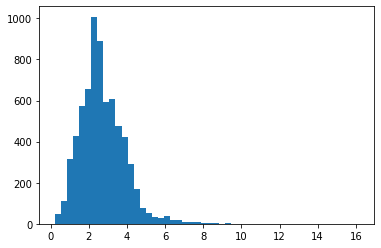

In [15]:
duration_list = np.array(duration_list)
plt.hist(duration_list, bins = 50)
print('longest cycle:{}'.format(max(duration_list)))
print('shortest cycle:{}'.format(min(duration_list)))
print('mean cycle:{}'.format(np.mean(duration_list)))
print('mean+std cycle:{}'.format(np.mean(duration_list)+2*np.std(duration_list)))


In [16]:
threshold =int(np.mean(duration_list)+2*np.std(duration_list))
print('Fraction of samples less than {} seconds:{}'.format(threshold,
                                                           np.sum(duration_list < threshold)/len(duration_list)))


Fraction of samples less than 5 seconds:0.9660771238040011


In [20]:
p_id_file = [] # patient IDs corresponding to each file
for name in filenames:
    p_id_file.append(int(name[:3]))

p_id_file = np.array(p_id_file) 

p_id_cndt = {} # patient IDs corresponding to each file
for i in range(df_diag.shape[0]):
    for j in range(p_id_file.shape[0]):
        if p_id_file[j]==df_diag['Patient number'][i]:
            p_id_cndt[j]=df_diag['Diagnosis'][i]
                 
filepaths = [join(path_data, f) for f in filenames]

labels = np.array([df_diag[df_diag['Patient number'] == x]['Diagnosis'].values[0] for x in p_id_file]) # labels for audio files


In [21]:
N_Data={}
Env_data_spl={}
Row_data_spl={}
labels_new=[]
p_id_new=[]
p_cndt_new = []

len_sec=5
pcs=4

for i in range(920):

    for j in range(pcs):

        labels_new.append(labels[i])
        p_id_new.append(p_id_file[i])
        p_cndt_new.append(p_id_cndt[i])

p_id_new=np.array(p_id_new)
labels_new=np.array(labels_new)

In [186]:
def XGBclass(Features,label,test_r):
    
    X_train, X_test, y_train, y_test = train_test_split(Features, label,
                                                        test_size=test_r,random_state=7)
    # fit model on training data
    model = XGBClassifier()
    model.fit(X_train, y_train)
    # make predictions for test data
    predictions = model.predict(X_test)
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
    return predictions,y_test,accuracy

In [229]:
def XGBclass(Features,label,test_r):
    
    X_train, X_test, y_train, y_test = train_test_split(Features, label,
                                                        test_size=test_r)
    # fit model on training data
    model = XGBClassifier()
    model.fit(X_train, y_train)
    # make predictions for test data
    predictions = model.predict(X_test)
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
    return predictions,y_test,accuracy

In [36]:
#Loading time features files
path='C:/Users/Setareh Erfani/Desktop/T_features_s.xlsx'
T_features_s=pd.read_excel(path)
T_features_s=T_features_s.iloc[:,1:T_features_s.shape[1]]
T_features_s=T_features_s.values


In [38]:
#Loading frequency feature files
path='C:/Users/Setareh Erfani/Desktop/F_features_s.xlsx'
F_features_s=pd.read_excel(path)
F_features_s=F_features_s.iloc[:,1:F_features_s.shape[1]]
F_features_s=F_features_s.values

In [37]:
#Loading sound feature files
path='C:/Users/Setareh Erfani/Desktop/S_features_s.xlsx'
S_features_s=pd.read_excel(path)
S_features_s=S_features_s.iloc[:,1:S_features_s.shape[1]]
S_features_s=S_features_s.values

In [25]:
# appending copd index with patient ids
COPD_idx=[] 
for idx in range(len(p_id_new)):
    if p_cndt_new[idx] == 'COPD':
        COPD_idx.append(idx)

COPD_idx=np.array(COPD_idx)

In [27]:
# appending healthy index with patient ids
healthy=[] 
for idx in range(len(p_id_new)):
    if p_cndt_new[idx] == 'Healthy':
        healthy.append(idx)
healthy=np.array(healthy)

In [31]:
# appending bronchiectasis index with patient ids
Bronchiectasis=[]      
for idx in range(len(p_id_new)):
    if p_cndt_new[idx] == 'Bronchiectasis':
        Bronchiectasis.append(idx)

Bronchiectasis=np.array(Bronchiectasis)

In [32]:
# appending bronchiolitis index with patient ids
Bronchiolitis=[]      
for idx in range(len(p_id_new)):
    if p_cndt_new[idx] == 'Bronchiolitis':
        Bronchiolitis.append(idx)

Bronchiolitis=np.array(Bronchiolitis)

In [33]:
# appending pnemonia index with patient ids
Pneumonia=[]      
for idx in range(len(p_id_new)):
    if p_cndt_new[idx] == 'Pneumonia':
        Pneumonia.append(idx)

Pneumonia=np.array(Pneumonia)

In [34]:
# appending lower respiratory tract infection with patient ids
LRTI=[]      
for idx in range(len(p_id_new)):
    if p_cndt_new[idx] == 'LRTI':
        LRTI.append(idx)

LRTI=np.array(LRTI)

In [35]:
# appending upper respiratory tract infection with patient ids
URTI=[]      
for idx in range(len(p_id_new)):
    if p_cndt_new[idx] == 'URTI':
        URTI.append(idx)

URTI=np.array(URTI)

# 3 Classes, Time features, Without feature selection

In [24]:
c_names = [ 'Healthy', 'COPD', 'Pneumonia']
num_clss = len(c_names)

N_smpls=140
N_features=goal_features.shape[1]

In [39]:
goal_features=T_features_s
goal_labels=np.array(labels_new)

[['Asthma' 'Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'LRTI'
  'Pneumonia' 'URTI']
 ['4' '64' '52' '3172' '140' '8' '148' '92']]


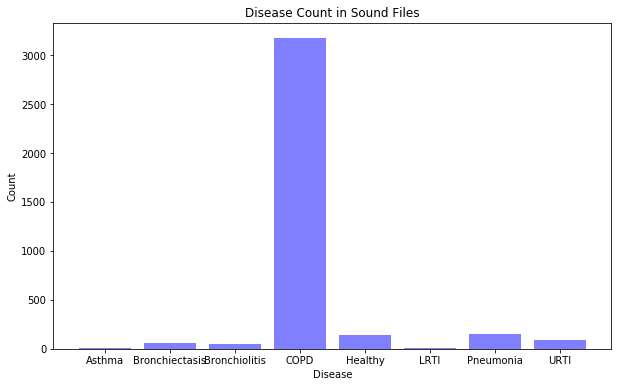

In [138]:
unique_elements, counts_elements = np.unique(labels_new, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))
#plot the quantity of conditions
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(10,6))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5,color='b')
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files')
plt.show()

Therefore, we have to down sample dataset in order to avoid overfitting.


In [40]:
healthy_sample=goal_features[healthy,:]
healthy_sample=healthy_sample.reshape(N_smpls,N_features)
l_h=0*np.ones(healthy_sample.shape[0])

In [41]:
copd_ids=pd.DataFrame(COPD_idx).sample(n = N_smpls) 
copd_ids = np.array(copd_ids)
copd_sample=goal_features[copd_ids,:]
copd_sample=copd_sample.reshape(N_smpls,N_features)
c_h=np.ones(copd_sample.shape[0])

In [42]:
Pneumonia_ids=pd.DataFrame(Pneumonia).sample(n = N_smpls) 
Pneumonia_ids = np.array(Pneumonia_ids)
Pneumonia_sample=goal_features[Pneumonia_ids,:]
Pneumonia_sample=Pneumonia_sample.reshape(N_smpls,N_features)
pn_h=2*np.ones(Pneumonia_sample.shape[0])


In [43]:
all_feats=np.vstack((healthy_sample,copd_sample,Pneumonia_sample))
  
i_labels_n=np.hstack((l_h,c_h,pn_h))

In [45]:
print(np.shape(healthy_sample))
print(np.shape(copd_sample))
print(np.shape(Pneumonia_sample))
print(np.shape(all_feats))
print(np.shape(i_labels_n))



(140, 19)
(140, 19)
(140, 19)
(420, 19)
(420,)


[[  0.   1.   2.]
 [140. 140. 140.]]


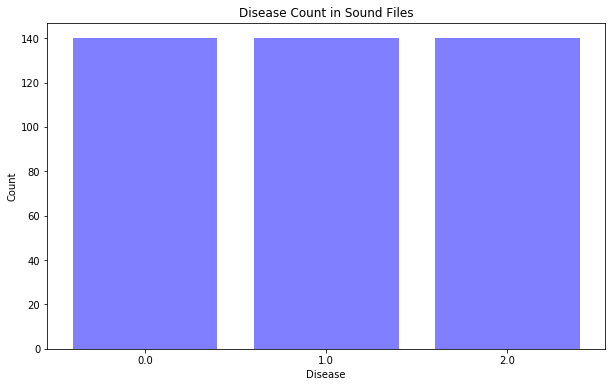

In [46]:

unique_elements, counts_elements = np.unique(i_labels_n, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))
#plot the quantity of conditions
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(10,6))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5,color='b')
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files')
plt.show()


In [47]:
XGB_pred,XGB_test,XGB_Acc=XGBclass(all_feats,i_labels_n,.25)

print(confusion_matrix(XGB_test, XGB_pred))


Accuracy: 60.95%
[[21 10  8]
 [ 5 21  5]
 [ 8  5 22]]


In [48]:
Oh_pred = to_categorical(XGB_pred) 
Oh_true = to_categorical(XGB_test)

In [52]:
# Classification Report
classification_results=sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names)
print(sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names))


              precision    recall  f1-score   support

     Healthy       0.62      0.54      0.58        39
        COPD       0.58      0.68      0.63        31
   Pneumonia       0.63      0.63      0.63        35

    accuracy                           0.61       105
   macro avg       0.61      0.61      0.61       105
weighted avg       0.61      0.61      0.61       105



# 3 Classes, Time features, With feature selection

In [53]:

def XGBRgrssr(Features,label,Train_R,B_Sc,N_Est,L_Rt):
    
    
    def get_feature_importance_data(Features,label,Train_R):
        
        y = label
        X = Features
    
        train_samples = int(X.shape[0] *Train_R)
 
        X_train = X[:train_samples]
        X_test = X[train_samples:]

        y_train = y[:train_samples]
        y_test = y[train_samples:]
    
        return (X_train, y_train), (X_test, y_test)

    (X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(Features,label,Train_R)

    regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=N_Est,base_score=B_Sc,colsample_bytree=1,learning_rate=L_Rt)

    xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)
    
    eval_result = regressor.evals_result()
    training_rounds = range(len(eval_result['validation_0']['rmse']))
    plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
    plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
    plt.xlabel('Iterations')
    plt.ylabel('RMSE')
    plt.title('Training Vs Validation Error')
    plt.legend()
    plt.show()
    features_score=xgbModel.feature_importances_
    features_score=features_score/max(features_score)
    fig = plt.figure()
    plt.xticks(rotation='vertical')
    X_test_FI=pd.DataFrame(X_test_FI)
    plt.bar([i for i in range(len(xgbModel.feature_importances_))], 
             xgbModel.feature_importances_/max(xgbModel.feature_importances_), tick_label=X_test_FI.columns)
    plt.title('Feature importance')
    plt.xlabel('Feature index')
    plt.ylabel('Normalized feature Score')
    plt.grid()
    plt.show()
    feature_idx=np.zeros((len(features_score)))
    for i in range(len(features_score)):
        if features_score[i]>B_Sc:
            feature_idx[i]=i
        else:
            feature_idx[i]=0
    feature_idx=feature_idx[feature_idx>0]
    
    return features_score,feature_idx

[12:08:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


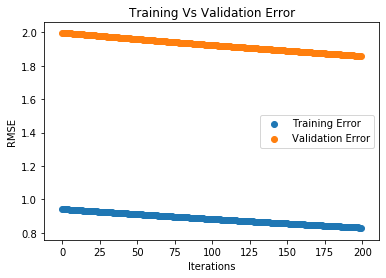

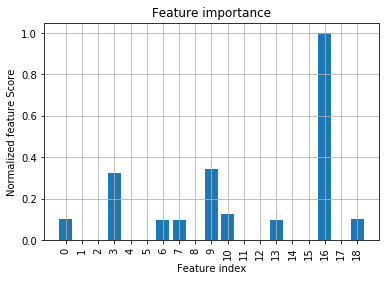

In [68]:
all_feats=np.vstack((healthy_sample,copd_sample,Pneumonia_sample))

i_labels_n=np.hstack((l_h,c_h,pn_h))

features_score,feature_idx=XGBRgrssr(all_feats,i_labels_n,.75,0,200,.001)

In [69]:
all_feats=pd.DataFrame(all_feats)[feature_idx]


XGB_pred,XGB_test,XGB_Acc=XGBclass(all_feats,i_labels_n,.25)

print(confusion_matrix(XGB_test, XGB_pred))

Accuracy: 69.52%
[[27  2  4]
 [ 7 24  8]
 [ 7  4 22]]


In [70]:
# Classification Report
classification_results=sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names)
print(sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names))


              precision    recall  f1-score   support

     Healthy       0.66      0.82      0.73        33
        COPD       0.80      0.62      0.70        39
   Pneumonia       0.65      0.67      0.66        33

    accuracy                           0.70       105
   macro avg       0.70      0.70      0.69       105
weighted avg       0.71      0.70      0.69       105



# 3 Classes, Frequency features, Without feature selection

In [74]:

goal_features=F_features_s
goal_labels=np.array(labels_new)

In [75]:

healthy_sample=goal_features[healthy,:]
healthy_sample=healthy_sample.reshape(N_smpls,N_features)
l_h=0*np.ones(healthy_sample.shape[0])

copd_ids=pd.DataFrame(COPD_idx).sample(n = N_smpls) 
copd_ids = np.array(copd_ids)
copd_sample=goal_features[copd_ids,:]
copd_sample=copd_sample.reshape(N_smpls,N_features)
c_h=np.ones(copd_sample.shape[0])


Pneumonia_ids=pd.DataFrame(Pneumonia).sample(n = N_smpls) 
Pneumonia_ids = np.array(Pneumonia_ids)
Pneumonia_sample=goal_features[Pneumonia_ids,:]
Pneumonia_sample=Pneumonia_sample.reshape(N_smpls,N_features)
pn_h=2*np.ones(Pneumonia_sample.shape[0])


In [76]:

all_feats=np.vstack((healthy_sample,copd_sample,Pneumonia_sample))
  
i_labels_n=np.hstack((l_h,c_h,pn_h))
Labels_eq=pd.DataFrame(['healthy','copd','Pneumonia'])


In [77]:

XGB_pred,XGB_test,XGB_Acc=XGBclass(all_feats,i_labels_n,.25)

print(confusion_matrix(XGB_test, XGB_pred))


Accuracy: 75.24%
[[23  0  6]
 [ 5 28  4]
 [ 6  5 28]]


In [78]:
# Classification Report
classification_results=sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names)
print(sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names))


              precision    recall  f1-score   support

     Healthy       0.68      0.79      0.73        29
        COPD       0.85      0.76      0.80        37
   Pneumonia       0.74      0.72      0.73        39

    accuracy                           0.75       105
   macro avg       0.75      0.76      0.75       105
weighted avg       0.76      0.75      0.75       105



# 3 Classes, Frequency features, With feature selection

In [81]:

all_feats=np.vstack((healthy_sample,copd_sample,Pneumonia_sample))
  
i_labels_n=np.hstack((l_h,c_h,pn_h))


[12:18:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


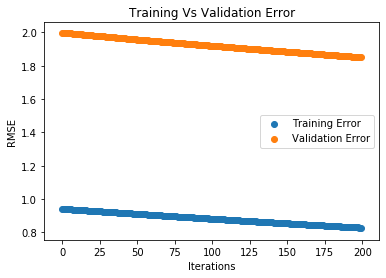

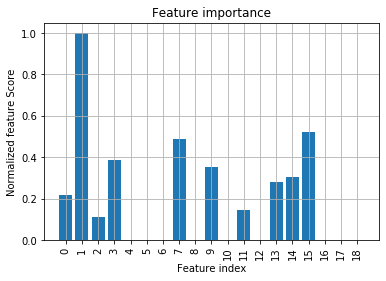

In [82]:

features_score,feature_idx=XGBRgrssr(all_feats,i_labels_n,.75,0,200,.001)

In [83]:

XGB_pred,XGB_test,XGB_Acc=XGBclass(all_feats,i_labels_n,.25)

print(confusion_matrix(XGB_test, XGB_pred))

Accuracy: 71.43%
[[25  0  7]
 [ 9 21  4]
 [ 6  4 29]]


In [84]:
# Classification Report
classification_results=sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names)
print(sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names))


              precision    recall  f1-score   support

     Healthy       0.62      0.78      0.69        32
        COPD       0.84      0.62      0.71        34
   Pneumonia       0.72      0.74      0.73        39

    accuracy                           0.71       105
   macro avg       0.73      0.71      0.71       105
weighted avg       0.73      0.71      0.71       105



In [ ]:
Oh_pred = to_categorical(XGB_pred) 
Oh_true = to_categorical(XGB_test) 

# 3 Classes, Sound features, Without feature selection

In [92]:
goal_features=S_features_s
goal_labels=np.array(labels_new)
N_smpls=140
N_features=goal_features.shape[1]


In [94]:
healthy_sample=goal_features[healthy,:]
l_h=0*np.ones(healthy_sample.shape[0])


In [95]:
copd_ids=pd.DataFrame(COPD_idx).sample(n = N_smpls) 
copd_ids = np.array(copd_ids)
copd_sample=goal_features[copd_ids,:]
copd_sample=copd_sample.reshape(N_smpls,N_features)
c_h=np.ones(copd_sample.shape[0])

In [96]:
Pneumonia_ids=pd.DataFrame(Pneumonia).sample(n = N_smpls) 
Pneumonia_ids = np.array(Pneumonia_ids)
Pneumonia_sample=goal_features[Pneumonia_ids,:]
Pneumonia_sample=Pneumonia_sample.reshape(N_smpls,N_features)
pn_h=2*np.ones(Pneumonia_sample.shape[0])


In [97]:
all_feats=np.vstack((healthy_sample,copd_sample,Pneumonia_sample))
  
i_labels_n=np.hstack((l_h,c_h,pn_h))

Labels_eq=pd.DataFrame(['healthy','copd','Pneumonia'])


In [98]:
XGB_pred,XGB_test,XGB_Acc=XGBclass(all_feats,i_labels_n,.25)

print(confusion_matrix(XGB_test, XGB_pred))



Accuracy: 88.57%
[[39  1  5]
 [ 1 35  2]
 [ 3  0 19]]


In [99]:
# Classification Report
classification_results=sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names)
print(sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names))


              precision    recall  f1-score   support

     Healthy       0.91      0.87      0.89        45
        COPD       0.97      0.92      0.95        38
   Pneumonia       0.73      0.86      0.79        22

    accuracy                           0.89       105
   macro avg       0.87      0.88      0.87       105
weighted avg       0.89      0.89      0.89       105



# 3 Classes, Sound features, With feature selection

In [109]:

all_feats=np.vstack((healthy_sample,copd_sample,Pneumonia_sample))
  
i_labels_n=np.hstack((l_h,c_h,pn_h))
Labels_eq=pd.DataFrame(['healthy','copd','Pneumonia'])


[12:29:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


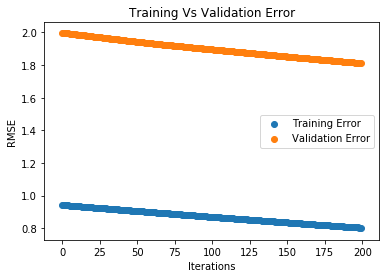

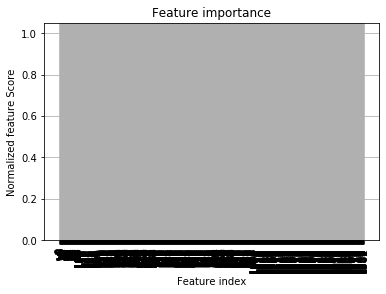

In [110]:
features_score,feature_idx=XGBRgrssr(all_feats,i_labels_n,.75,0,200,.001)


In [133]:
all_feats=pd.DataFrame(all_feats)[feature_idx]

all_feats=np.array(all_feats)

XGB_pred,XGB_test,XGB_Acc=XGBclass(all_feats,i_labels_n,.25)

print(confusion_matrix(XGB_test, XGB_pred))

Accuracy: 92.38%
[[25  0  3]
 [ 1 36  2]
 [ 2  0 36]]


In [134]:
# Classification Report
classification_results=sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names)
print(sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names))



              precision    recall  f1-score   support

     Healthy       0.89      0.89      0.89        28
        COPD       1.00      0.92      0.96        39
   Pneumonia       0.88      0.95      0.91        38

    accuracy                           0.92       105
   macro avg       0.92      0.92      0.92       105
weighted avg       0.93      0.92      0.92       105



Feature selection has improved classification accuracy based on time and sound features but decreased classification accuracy based on Frequency features. Because, sound and time features suffer from noise and feature selection will help them to eliminate noise. 

# 5 Classes, Time features, Without feature selection

In [139]:
goal_features=T_features_s
goal_labels=np.array(labels_new)

In [140]:

c_names = [ 'Bronchiectasis', 'COPD', 'Healthy' ,'Pneumonia', 'URTI']
num_clss = len(c_names)

N_smpls=60
N_features=goal_features.shape[1]

In [141]:

Bronchiectasis_ids=pd.DataFrame(Bronchiectasis).sample(n = N_smpls) 
Bronchiectasis_ids = np.array(Bronchiectasis_ids)
Bronchiectasis_sample=goal_features[Bronchiectasis_ids,:]
Bronchiectasis_sample=Bronchiectasis_sample.reshape(N_smpls,N_features)
BR_h=0*np.ones(Bronchiectasis_sample.shape[0])


copd_ids=pd.DataFrame(COPD_idx).sample(n = N_smpls) 
copd_ids = np.array(copd_ids)
copd_sample=goal_features[copd_ids,:]
copd_sample=copd_sample.reshape(N_smpls,N_features)
c_h=np.ones(copd_sample.shape[0])

healthy_ids=pd.DataFrame(healthy).sample(n = N_smpls) 
healthy_ids = np.array(healthy_ids)
healthy_sample=goal_features[healthy_ids,:]
healthy_sample=healthy_sample.reshape(N_smpls,N_features)
l_h=2*np.ones(healthy_sample.shape[0])


Pneumonia_ids=pd.DataFrame(Pneumonia).sample(n = N_smpls) 
Pneumonia_ids = np.array(Pneumonia_ids)
Pneumonia_sample=goal_features[Pneumonia_ids,:]
Pneumonia_sample=Pneumonia_sample.reshape(N_smpls,N_features)
pn_h=3*np.ones(Pneumonia_sample.shape[0])

URTI_ids=pd.DataFrame(URTI).sample(n = N_smpls) 
URTI_ids = np.array(URTI_ids)
URTI_sample=goal_features[URTI_ids,:]
URTI_sample=URTI_sample.reshape(N_smpls,N_features)
URTI_h=4*np.ones(URTI_sample.shape[0])

In [145]:
all_feats=np.vstack((Bronchiectasis_sample,copd_sample,healthy_sample,Pneumonia_sample,URTI_sample))
np.shape(all_feats)  
i_labels_n=np.hstack((BR_h,c_h,l_h,pn_h,URTI_h))


[[ 0.  1.  2.  3.  4.]
 [60. 60. 60. 60. 60.]]


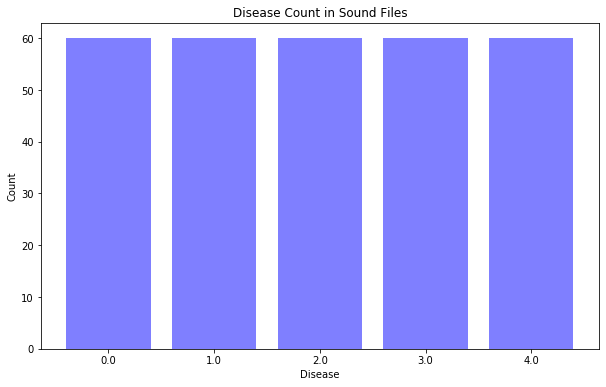

In [143]:
unique_elements, counts_elements = np.unique(i_labels_n, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))
#plot the quantity of conditions
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(10,6))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5,color='b')
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files')
plt.show()

In [151]:
XGB_pred,XGB_test,XGB_Acc=XGBclass(all_feats,i_labels_n,.25)

print(confusion_matrix(XGB_test, XGB_pred))

Accuracy: 61.33%
[[12  0  0  0  1]
 [ 1 12  0  1  1]
 [ 0  1  7  3  4]
 [ 0  3  5 10  2]
 [ 0  5  1  1  5]]


In [152]:
# Classification Report
classification_results=sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names)
print(sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names))


                precision    recall  f1-score   support

Bronchiectasis       0.92      0.92      0.92        13
          COPD       0.57      0.80      0.67        15
       Healthy       0.54      0.47      0.50        15
     Pneumonia       0.67      0.50      0.57        20
          URTI       0.38      0.42      0.40        12

      accuracy                           0.61        75
     macro avg       0.62      0.62      0.61        75
  weighted avg       0.62      0.61      0.61        75



# 5 Classes, Time features, With feature selection

In [155]:
all_feats=np.vstack((Bronchiectasis_sample,copd_sample,healthy_sample,Pneumonia_sample,URTI_sample))
np.shape(all_feats)  
i_labels_n=np.hstack((BR_h,c_h,l_h,pn_h,URTI_h))

[12:54:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


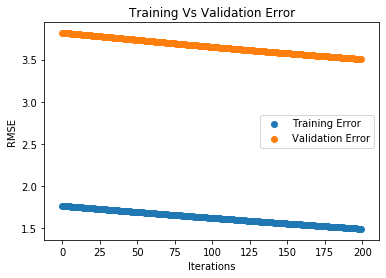

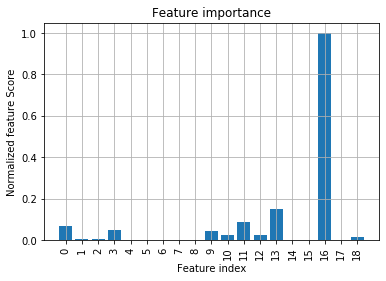

In [156]:
features_score,feature_idx=XGBRgrssr(all_feats,i_labels_n,.75,0,200,.001)


In [167]:
all_feats=pd.DataFrame(all_feats)[feature_idx]

XGB_pred,XGB_test,XGB_Acc=XGBclass(all_feats,i_labels_n,.25)

print(confusion_matrix(XGB_test, XGB_pred))

Accuracy: 60.00%
[[17  0  0  0  2]
 [ 2 11  1  2  0]
 [ 0  1  1  4  7]
 [ 0  1  1  9  3]
 [ 1  1  3  1  7]]


In [168]:
# Classification Report
classification_results=sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names)
print(sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names))


                precision    recall  f1-score   support

Bronchiectasis       0.85      0.89      0.87        19
          COPD       0.79      0.69      0.73        16
       Healthy       0.17      0.08      0.11        13
     Pneumonia       0.56      0.64      0.60        14
          URTI       0.37      0.54      0.44        13

      accuracy                           0.60        75
     macro avg       0.55      0.57      0.55        75
  weighted avg       0.58      0.60      0.58        75



Feature selection shows NO effect on classification accuracy

# 5 Classes, Frequency features, Without feature selection

In [173]:
goal_features=F_features_s
goal_labels=np.array(labels_new)
N_features=goal_features.shape[1]

In [174]:
Bronchiectasis_ids=pd.DataFrame(Bronchiectasis).sample(n = N_smpls) 
Bronchiectasis_ids = np.array(Bronchiectasis_ids)
Bronchiectasis_sample=goal_features[Bronchiectasis_ids,:]
Bronchiectasis_sample=Bronchiectasis_sample.reshape(N_smpls,N_features)
BR_h=0*np.ones(Bronchiectasis_sample.shape[0])


copd_ids=pd.DataFrame(COPD_idx).sample(n = N_smpls) 
copd_ids = np.array(copd_ids)
copd_sample=goal_features[copd_ids,:]
copd_sample=copd_sample.reshape(N_smpls,N_features)
c_h=np.ones(copd_sample.shape[0])

healthy_ids=pd.DataFrame(healthy).sample(n = N_smpls) 
healthy_ids = np.array(healthy_ids)
healthy_sample=goal_features[healthy_ids,:]
healthy_sample=healthy_sample.reshape(N_smpls,N_features)
l_h=2*np.ones(healthy_sample.shape[0])


Pneumonia_ids=pd.DataFrame(Pneumonia).sample(n = N_smpls) 
Pneumonia_ids = np.array(Pneumonia_ids)
Pneumonia_sample=goal_features[Pneumonia_ids,:]
Pneumonia_sample=Pneumonia_sample.reshape(N_smpls,N_features)
pn_h=3*np.ones(Pneumonia_sample.shape[0])

URTI_ids=pd.DataFrame(URTI).sample(n = N_smpls) 
URTI_ids = np.array(URTI_ids)
URTI_sample=goal_features[URTI_ids,:]
URTI_sample=URTI_sample.reshape(N_smpls,N_features)
URTI_h=4*np.ones(URTI_sample.shape[0])

In [175]:
all_feats=np.vstack((Bronchiectasis_sample,copd_sample,healthy_sample,Pneumonia_sample,URTI_sample))
np.shape(all_feats)  
i_labels_n=np.hstack((BR_h,c_h,l_h,pn_h,URTI_h))


In [176]:
XGB_pred,XGB_test,XGB_Acc=XGBclass(all_feats,i_labels_n,.25)

print(confusion_matrix(XGB_test, XGB_pred))

Accuracy: 65.33%
[[18  0  1  0  1]
 [ 1 11  1  1  0]
 [ 0  0  4  4  5]
 [ 0  3  1  6  2]
 [ 1  2  1  2 10]]


In [177]:
# Classification Report
classification_results=sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names)
print(sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names))


                precision    recall  f1-score   support

Bronchiectasis       0.90      0.90      0.90        20
          COPD       0.69      0.79      0.73        14
       Healthy       0.50      0.31      0.38        13
     Pneumonia       0.46      0.50      0.48        12
          URTI       0.56      0.62      0.59        16

      accuracy                           0.65        75
     macro avg       0.62      0.62      0.62        75
  weighted avg       0.65      0.65      0.65        75



# 5 Classes, Frequency features, With feature selection

In [180]:
all_feats=np.vstack((Bronchiectasis_sample,copd_sample,healthy_sample,Pneumonia_sample,URTI_sample))
np.shape(all_feats)  
i_labels_n=np.hstack((BR_h,c_h,l_h,pn_h,URTI_h))


[13:01:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


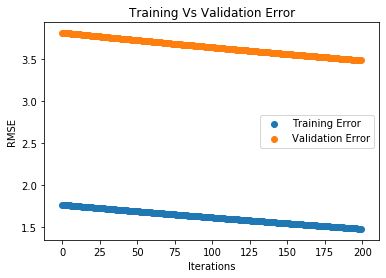

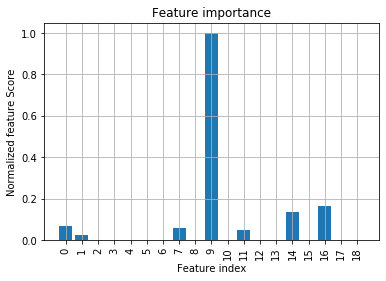

In [181]:
features_score,feature_idx=XGBRgrssr(all_feats,i_labels_n,.75,0,200,.001)

all_feats=pd.DataFrame(all_feats)[feature_idx]


In [185]:
XGB_pred,XGB_test,XGB_Acc=XGBclass(all_feats,i_labels_n,.25)

print(confusion_matrix(XGB_test, XGB_pred))

Accuracy: 72.00%
[[14  0  1  0  1]
 [ 0 19  0  0  0]
 [ 0  0  7  1  3]
 [ 0  0  3  9  3]
 [ 0  2  6  1  5]]


# 5 Classes, Sound features, Without feature selection

In [188]:
goal_features=S_features_s
goal_labels=np.array(labels_new)
N_features=goal_features.shape[1]
print(N_features)

1563


In [189]:
Bronchiectasis_ids=pd.DataFrame(Bronchiectasis).sample(n = N_smpls) 
Bronchiectasis_ids = np.array(Bronchiectasis_ids)
Bronchiectasis_sample=goal_features[Bronchiectasis_ids,:]
Bronchiectasis_sample=Bronchiectasis_sample.reshape(N_smpls,N_features)
BR_h=0*np.ones(Bronchiectasis_sample.shape[0])


copd_ids=pd.DataFrame(COPD_idx).sample(n = N_smpls) 
copd_ids = np.array(copd_ids)
copd_sample=goal_features[copd_ids,:]
copd_sample=copd_sample.reshape(N_smpls,N_features)
c_h=np.ones(copd_sample.shape[0])

healthy_ids=pd.DataFrame(healthy).sample(n = N_smpls) 
healthy_ids = np.array(healthy_ids)
healthy_sample=goal_features[healthy_ids,:]
healthy_sample=healthy_sample.reshape(N_smpls,N_features)
l_h=2*np.ones(healthy_sample.shape[0])


Pneumonia_ids=pd.DataFrame(Pneumonia).sample(n = N_smpls) 
Pneumonia_ids = np.array(Pneumonia_ids)
Pneumonia_sample=goal_features[Pneumonia_ids,:]
Pneumonia_sample=Pneumonia_sample.reshape(N_smpls,N_features)
pn_h=3*np.ones(Pneumonia_sample.shape[0])

URTI_ids=pd.DataFrame(URTI).sample(n = N_smpls) 
URTI_ids = np.array(URTI_ids)
URTI_sample=goal_features[URTI_ids,:]
URTI_sample=URTI_sample.reshape(N_smpls,N_features)
URTI_h=4*np.ones(URTI_sample.shape[0])


In [190]:
all_feats=np.vstack((Bronchiectasis_sample,copd_sample,healthy_sample,Pneumonia_sample,URTI_sample))
np.shape(all_feats)  
i_labels_n=np.hstack((BR_h,c_h,l_h,pn_h,URTI_h))


In [193]:
XGB_pred,XGB_test,XGB_Acc=XGBclass(all_feats,i_labels_n,.25)

print(confusion_matrix(XGB_test, XGB_pred))

Accuracy: 73.33%
[[ 7  0  0  1  0]
 [ 0 17  0  4  0]
 [ 0  0 11  1  3]
 [ 0  0  0 10  1]
 [ 0  2  7  1 10]]


In [194]:
# Classification Report
classification_results=sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names)
print(sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names))


                precision    recall  f1-score   support

Bronchiectasis       1.00      0.88      0.93         8
          COPD       0.89      0.81      0.85        21
       Healthy       0.61      0.73      0.67        15
     Pneumonia       0.59      0.91      0.71        11
          URTI       0.71      0.50      0.59        20

      accuracy                           0.73        75
     macro avg       0.76      0.77      0.75        75
  weighted avg       0.76      0.73      0.73        75



# 5 Classes, Sound features, With feature selection

In [197]:
all_feats=np.vstack((Bronchiectasis_sample,copd_sample,healthy_sample,Pneumonia_sample,URTI_sample))
np.shape(all_feats)  
i_labels_n=np.hstack((BR_h,c_h,l_h,pn_h,URTI_h))

[13:07:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


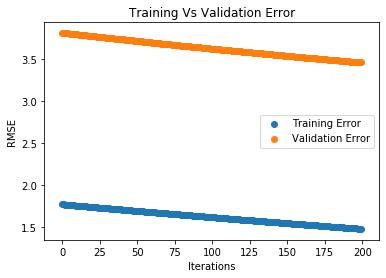

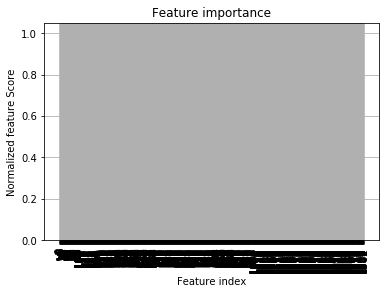

In [198]:
features_score,feature_idx=XGBRgrssr(all_feats,i_labels_n,.75,0,200,.001)

all_feats=pd.DataFrame(all_feats)[feature_idx]


In [200]:
XGB_pred,XGB_test,XGB_Acc=XGBclass(all_feats,i_labels_n,.25)

print(confusion_matrix(XGB_test, XGB_pred))

Accuracy: 62.67%
[[ 5  0  1  1  1]
 [ 0 15  1  5  0]
 [ 1  0  7  3  4]
 [ 0  0  1 10  0]
 [ 0  0  9  1 10]]


In [201]:
# Classification Report
classification_results=sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names)
print(sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names))


                precision    recall  f1-score   support

Bronchiectasis       0.83      0.62      0.71         8
          COPD       1.00      0.71      0.83        21
       Healthy       0.37      0.47      0.41        15
     Pneumonia       0.50      0.91      0.65        11
          URTI       0.67      0.50      0.57        20

      accuracy                           0.63        75
     macro avg       0.67      0.64      0.64        75
  weighted avg       0.69      0.63      0.64        75



# 6 Classes (Imbalance data), Time features, Without feature selection

In [209]:
c_names = ['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']
num_clss = len(c_names)

goal_features=T_features_s
goal_labels=np.array(labels_new)
print(np.shape(goal_features))
print(np.shape(goal_labels))

(3680, 19)
(3680,)


In addition, Ashtma and LTRI should be removed since theier quantity is 4 and 8 samples and it would not be enough for training and testing Machine Learning methods such as XGB, SVM and LSTM

In [210]:
goal_features= np.delete(goal_features, np.where((goal_labels == 'Asthma') | (goal_labels == 'LRTI'))[0], axis=0) 
goal_labels = np.delete(goal_labels, np.where((goal_labels == 'Asthma') | (goal_labels == 'LRTI'))[0], axis=0)
print(np.shape(goal_features))
print(np.shape(goal_labels))

(3668, 19)
(3668,)


[['Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'Pneumonia' 'URTI']
 ['64' '52' '3172' '140' '148' '92']]


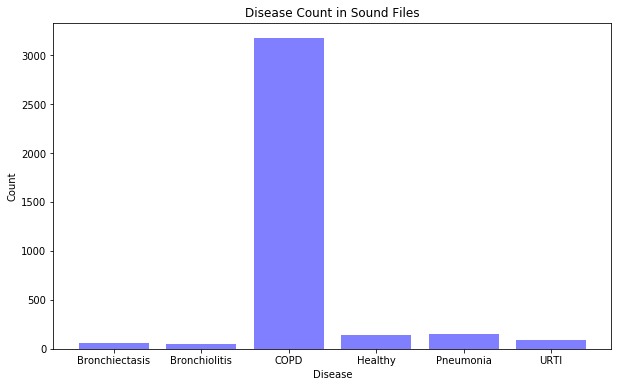

In [212]:
unique_elements, counts_elements = np.unique(goal_labels, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))
#plot the quantity of conditions
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(10,6))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5,color='b')
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files')
plt.show()

In [213]:
le = LabelEncoder()
i_labels = le.fit_transform(goal_labels)

In [214]:
XGB_pred,XGB_test,XGB_Acc=XGBclass(goal_features,i_labels,.25)

print(confusion_matrix(XGB_test, XGB_pred))

Accuracy: 85.93%
[[  2   0  19   0   0   0]
 [  0   0  13   1   0   1]
 [  1   1 784   0   2   0]
 [  0   0  38   1   0   3]
 [  0   0  29   0   0   0]
 [  0   0  20   1   0   1]]


In [216]:
# Classification Report
classification_results=sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names)
print(sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names))


                precision    recall  f1-score   support

Bronchiectasis       0.67      0.10      0.17        21
 Bronchiolitis       0.00      0.00      0.00        15
          COPD       0.87      0.99      0.93       788
       Healthy       0.33      0.02      0.04        42
     Pneumonia       0.00      0.00      0.00        29
          URTI       0.20      0.05      0.07        22

      accuracy                           0.86       917
     macro avg       0.34      0.19      0.20       917
  weighted avg       0.78      0.86      0.80       917



# 6 Classes (Imbalance data), Time features, With feature selection

[13:23:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


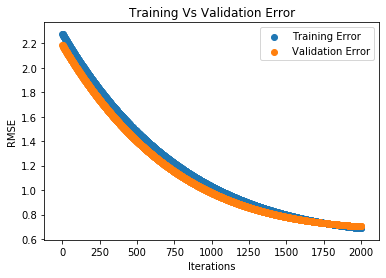

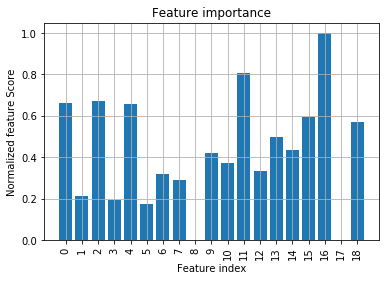

In [220]:
features_score,feature_idx=XGBRgrssr(goal_features,i_labels,.75,0,2000,.001)
goal_features=pd.DataFrame(goal_features)[feature_idx]


In [221]:
XGB_pred,XGB_test,XGB_Acc=XGBclass(goal_features,i_labels,.25)

print(confusion_matrix(XGB_test, XGB_pred))

Accuracy: 86.04%
[[  2   0  19   0   0   0]
 [  0   0  14   1   0   0]
 [  1   1 784   0   2   0]
 [  0   0  39   1   0   2]
 [  0   0  29   0   0   0]
 [  0   0  19   1   0   2]]


Overfitting can be seen. The accuracy is high but it is not reliable
Feature selection was not able to eliminate effect of overfitting.

# 6 Classes (Imbalance data), Frequency features, Without feature selection

In [222]:
goal_features=F_features_s
goal_labels=np.array(labels_new)

In [223]:
goal_features = np.delete(goal_features, np.where((goal_labels == 'Asthma') | (goal_labels == 'LRTI'))[0], axis=0) 
goal_labels = np.delete(goal_labels, np.where((goal_labels == 'Asthma') | (goal_labels == 'LRTI'))[0], axis=0)


In [224]:
le = LabelEncoder()
i_labels = le.fit_transform(goal_labels)

In [235]:
XGB_pred,XGB_test,XGB_Acc=XGBclass(goal_features,i_labels,.25)

print(confusion_matrix(XGB_test, XGB_pred))

Accuracy: 88.55%
[[  4   0  11   0   0   0]
 [  0   0  11   1   0   1]
 [  3   1 802   1   0   1]
 [  0   0  26   3   2   1]
 [  0   0  28   0   3   0]
 [  0   0  15   3   0   0]]


In [236]:
# Classification Report
classification_results=sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names)
print(sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names))


                precision    recall  f1-score   support

Bronchiectasis       0.57      0.27      0.36        15
 Bronchiolitis       0.00      0.00      0.00        13
          COPD       0.90      0.99      0.94       808
       Healthy       0.38      0.09      0.15        32
     Pneumonia       0.60      0.10      0.17        31
          URTI       0.00      0.00      0.00        18

      accuracy                           0.89       917
     macro avg       0.41      0.24      0.27       917
  weighted avg       0.83      0.89      0.85       917



# 6 Classes (Imbalance data), Frequency features, With feature selection

In [244]:
goal_features=F_features_s
goal_labels=np.array(labels_new)

goal_features = np.delete(goal_features, np.where((goal_labels == 'Asthma') | (goal_labels == 'LRTI'))[0], axis=0) 
goal_labels = np.delete(goal_labels, np.where((goal_labels == 'Asthma') | (goal_labels == 'LRTI'))[0], axis=0)

le = LabelEncoder()
i_labels = le.fit_transform(goal_labels)

[13:34:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


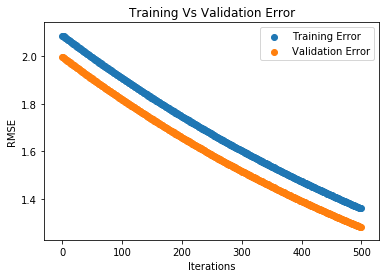

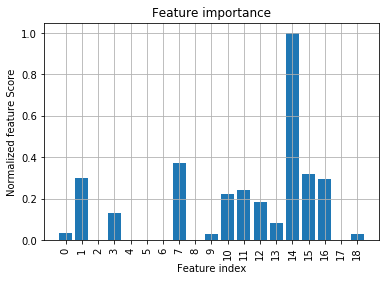

In [245]:
features_score,feature_idx=XGBRgrssr(goal_features,i_labels,.75,0.2,500,.001)

goal_features=pd.DataFrame(goal_features)[feature_idx]


In [246]:
XGB_pred,XGB_test,XGB_Acc=XGBclass(goal_features,i_labels,.25)

print(confusion_matrix(XGB_test, XGB_pred))

Accuracy: 86.04%
[[  4   0   8   0   0   0]
 [  0   0  20   0   0   0]
 [  1   0 783   2   5   0]
 [  0   0  34   1   1   1]
 [  0   0  39   0   0   0]
 [  0   0  16   1   0   1]]


In [247]:
# Classification Report
classification_results=sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names)
print(sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names))


                precision    recall  f1-score   support

Bronchiectasis       0.80      0.33      0.47        12
 Bronchiolitis       0.00      0.00      0.00        20
          COPD       0.87      0.99      0.93       791
       Healthy       0.25      0.03      0.05        37
     Pneumonia       0.00      0.00      0.00        39
          URTI       0.50      0.06      0.10        18

      accuracy                           0.86       917
     macro avg       0.40      0.23      0.26       917
  weighted avg       0.78      0.86      0.81       917



# 6 Classes (Imbalance data), Sound features, Without feature selection

In [250]:
goal_features=S_features_s
goal_labels=np.array(labels_new)

goal_features = np.delete(goal_features, np.where((goal_labels == 'Asthma') | (goal_labels == 'LRTI'))[0], axis=0) 
goal_labels = np.delete(goal_labels, np.where((goal_labels == 'Asthma') | (goal_labels == 'LRTI'))[0], axis=0)

le = LabelEncoder()
i_labels = le.fit_transform(goal_labels)

In [255]:
XGB_pred,XGB_test,XGB_Acc=XGBclass(goal_features,i_labels,.25)

print(confusion_matrix(XGB_test, XGB_pred))

Accuracy: 92.80%
[[ 13   1   3   0   0   2]
 [  0   4   0   4   0   3]
 [  0   0 782   2   3   0]
 [  0   1  10  25   2   5]
 [  0   0  13   2  22   1]
 [  0   2   5   6   1   5]]


In [256]:
# Classification Report
classification_results=sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names)
print(sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names))


                precision    recall  f1-score   support

Bronchiectasis       1.00      0.68      0.81        19
 Bronchiolitis       0.50      0.36      0.42        11
          COPD       0.96      0.99      0.98       787
       Healthy       0.64      0.58      0.61        43
     Pneumonia       0.79      0.58      0.67        38
          URTI       0.31      0.26      0.29        19

      accuracy                           0.93       917
     macro avg       0.70      0.58      0.63       917
  weighted avg       0.92      0.93      0.92       917



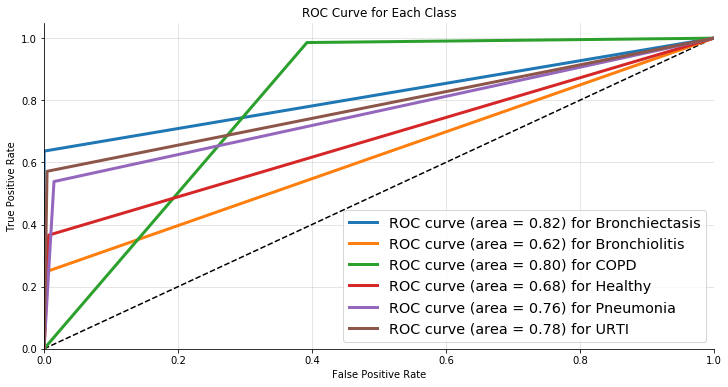

In [253]:
Oh_pred = to_categorical(XGB_pred) 
Oh_true = to_categorical(XGB_test) 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_clss):
    fpr[i], tpr[i],_= roc_curve(Oh_true[:, i], Oh_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])



# Plot ROC curves
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(num_clss):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="lower right", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [257]:
AUc=[]
for i in range(num_clss):
    AUc.append(sklearn.metrics.auc(fpr[i], tpr[i]))

print(AUc)
print(np.mean(AUc))

[0.8181818181818181, 0.6222375690607735, 0.7966704556218623, 0.679502171734046, 0.76182758016471, 0.7834821428571429]
0.7436502896033921


The Sound features seem to help features to overcome overfitting. 

# 6 Classes (Imbalance data), Sound features, With feature selection

In [258]:
goal_features=S_features_s
goal_labels=np.array(labels_new)

goal_features = np.delete(goal_features, np.where((goal_labels == 'Asthma') | (goal_labels == 'LRTI'))[0], axis=0) 
goal_labels = np.delete(goal_labels, np.where((goal_labels == 'Asthma') | (goal_labels == 'LRTI'))[0], axis=0)

le = LabelEncoder()
i_labels = le.fit_transform(goal_labels)

[13:46:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


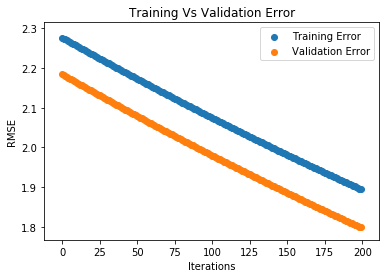

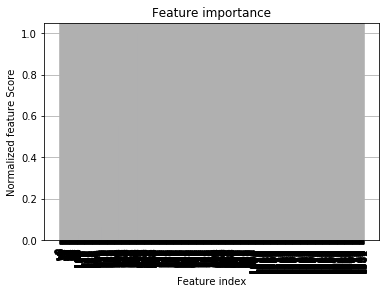

In [259]:
features_score,feature_idx=XGBRgrssr(goal_features,i_labels,.75,0,200,.001)
goal_features=pd.DataFrame(goal_features)[feature_idx]


In [260]:
XGB_pred,XGB_test,XGB_Acc=XGBclass(goal_features,i_labels,.25)

print(confusion_matrix(XGB_test, XGB_pred))

Accuracy: 91.60%
[[ 15   0   4   0   0   0]
 [  0   5   5   1   0   1]
 [  4   0 782   5   4   1]
 [  0   1  11  12   4   5]
 [  0   0  18   3  15   0]
 [  0   2   4   4   0  11]]


In [261]:
# Classification Report
classification_results=sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names)
print(sklearn.metrics.classification_report(XGB_test, XGB_pred, target_names=c_names))


                precision    recall  f1-score   support

Bronchiectasis       0.79      0.79      0.79        19
 Bronchiolitis       0.62      0.42      0.50        12
          COPD       0.95      0.98      0.97       796
       Healthy       0.48      0.36      0.41        33
     Pneumonia       0.65      0.42      0.51        36
          URTI       0.61      0.52      0.56        21

      accuracy                           0.92       917
     macro avg       0.68      0.58      0.62       917
  weighted avg       0.91      0.92      0.91       917



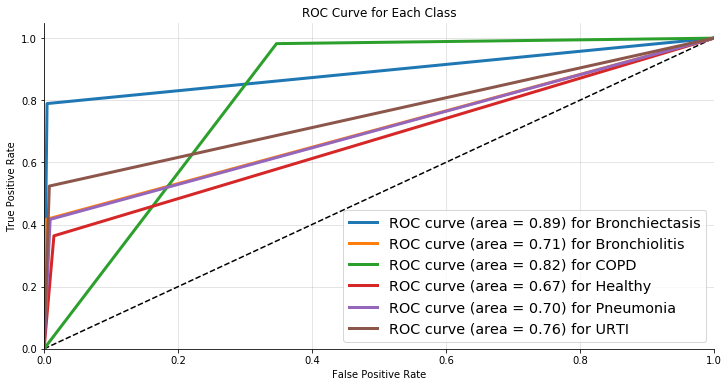

In [262]:
Oh_pred = to_categorical(XGB_pred) 
Oh_true = to_categorical(XGB_test) 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_clss):
    fpr[i], tpr[i],_= roc_curve(Oh_true[:, i], Oh_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])



# Plot ROC curves
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(num_clss):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="lower right", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [263]:
AUc=[]
for i in range(num_clss):
    AUc.append(sklearn.metrics.auc(fpr[i], tpr[i]))

print(AUc)
print(np.mean(AUc))

[0.8925096706130582, 0.7066758747697975, 0.8176523111424893, 0.6744652406417113, 0.7037930382141506, 0.7579985119047619]
0.7588491078809948
